# Plot effects of endo12K inserts on mRNA levels

## Load libraries and define analysis-specific parameters

- We need to install both rsample and rasilabRtemplates in the Docker / Singularity container (or R conda environement?)

In [90]:
library(tidyverse)
#library(rsample)
#library(rasilabRtemplates)

# Color-blind friendly palette. See http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

## Read back barcode counts 

- Barcode counts tsv file generated in [plot_alignment_statistics.ipynb](https://github.com/rasilab/burke_2022/blob/master/analysis/barcode_seq/pool3_mrna/scripts/plot_alignment_statistics.ipynb).

In [91]:
barcode_counts <- read_tsv("../tables/sample_insert_barcode_counts.tsv.gz") %>% 
  print()

Rows: 1239853 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): sample_id, sample_name, library_type, linkage_ref
dbl (4): insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 1,239,853 × 8
   sample_id sample_name  insert_num barcode_num barcode_count linkage_count
   <chr>     <chr>             <dbl>       <dbl>         <dbl>         <dbl>
 1 139p3     endo12k_grna      11701      703859          2761           160
 2 139p3     endo12k_grna       8488      702091          2454           111
 3 139p3     endo12k_grna       5595      700776          2317           101
 4 139p3     endo12k_grna       5919      703070          2273           124
 5 139p3     endo12k_grna       5335      701636          2250           107
 6 139p3     endo12k_grna       2024      703956          2229           178
 7 139p3     endo12k_grna       5704      645101          2123            49
 8 139p3     endo12k_grna       5512      703225          2048           127
 9 139p3     endo12k_grna       5643      383253          2026            18
10 139p3     endo12k_grna       5481      700548          2020           100
# … with 1,239,843 more rows, and 2 more variables

## Read insert annotations 

In [92]:
insert_annotations <- read_tsv("../../pool3_linkage/annotations/insert_annotations/endo12k.tsv.gz") %>% 
  print()

Rows: 12000 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): group, mutant_type, motif_source, aa, seq, gene_name, transcript_id...
dbl (4): motif_num, strength, loc, insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 12,000 × 12
   group motif_num mutant_type strength motif_source       aa    seq   gene_name
   <chr>     <dbl> <chr>          <dbl> <chr>              <chr> <chr> <chr>    
 1 human      1760 VnextK             6 weber_2020_dbndd_… LLLF… CTGC… DBNDD2_m…
 2 human      1760 KnextV             6 weber_2020_dbndd_… RRRR… CGGC… DBNDD2_m…
 3 human      1760 wildtype           6 weber_2020_dbndd_… DPNP… GACC… DBNDD2_m…
 4 human      1760 VnextK             6 weber_2020_dbndd_… LLLF… CTGC… DBNDD2_m…
 5 human      1760 KnextV             6 weber_2020_dbndd_… RRRR… CGGC… DBNDD2_m…
 6 human      1760 wildtype           6 weber_2020_dbndd_… DPNP… GACC… DBNDD2_m…
 7 human      2446 VnextK            NA control_motifs     SGSG… TCCG… NA       
 8 human      2445 VnextK            NA control_motifs     FFFF… TTTT… NA       
 9 human      2444 VnextK            NA control_motifs     VVVV… GTTG… NA       
10 human      2443 VnextK            NA control_motifs     FFFF… TTCT… NA       
# … 

## Combine barcode counts and insert annotations

Filter for inserts with at least 6 barcodes total and 200 reads total

In [93]:
lfc <- barcode_counts %>% 
  group_by(insert_num, library_type) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  pivot_wider(names_from = library_type, values_from = c("count", "n_barcodes")) %>%
  filter(count_grna + count_mrna >= insert_reads_cutoff) %>%
  filter(n_barcodes_grna + n_barcodes_mrna >= n_barcodes_cutoff) %>%
  mutate(lfc = log2(count_mrna) - log2(count_grna)) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc) %>%
  select(motif_source, gene_name, motif_type, mutant_type, strength, lfc, aa, everything(), -motif_num, -group, -insert_num) %>% 
  write_tsv("../tables/insert_lfc.tsv") %>% 
  print()

`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


# A tibble: 11,978 × 14
   motif_source gene_name motif_type mutant_type strength   lfc aa         seq  
   <chr>        <chr>     <chr>      <chr>          <dbl> <dbl> <chr>      <chr>
 1 rg4          HES4      NA         NA                NA -4.16 RKVGSRPGV… CGCA…
 2 rg4          MACROD1   NA         NA                NA -3.84 GRRARTSAG… GGCC…
 3 rg4          WDR26     NA         NA                NA -3.65 AGGGGGGGG… GCAG…
 4 rg4          CAPNS1    NA         NA                NA -3.59 FLKGGGGGG… TTCT…
 5 rg4          HNRNPL    NA         NA                NA -3.45 HGGGGGGGG… CACG…
 6 rg4          PGRMC2    NA         NA                NA -3.33 MLGAYRLWV… CTGC…
 7 rg4          LRRC58    NA         NA                NA -3.24 ETLESELEA… GAGA…
 8 rg4          C9orf40   NA         NA                NA -3.16 PGEELPGAR… CCGG…
 9 hiv1         vpu_64    NA         NA                NA -3.05 VWSIVIIEY… GTGT…
10 rg4          VEGFA     NA         NA                NA -2.93 AASRGQGPE… GCGG…
# … 

## What is the median number of barcodes per insert

In [94]:
lfc %>% 
  summarize(median_grna_barcodes = median(n_barcodes_grna),
            median_mrna_barcodes = median(n_barcodes_mrna))

median_grna_barcodes,median_mrna_barcodes
<dbl>,<dbl>
47,50


## Compare LFC for strong wildtype VK-type motifs vs controls 

- The goal here is to compare VK-type motifs of strength >= 10 with endogenous control motifs that do not have VK-type motifs. The only such group we included in our experiment is the han2020 control motifs. These have strength <= 2. There are 122 of them.

# A tibble: 1,201 × 15
   motif_source      gene_name motif_type mutant_type strength   lfc aa    seq  
   <chr>             <chr>     <chr>      <chr>          <dbl> <dbl> <chr> <chr>
 1 human_vk_motif_10 ADORA3    stall      wildtype          14 -2.60 LLAI… TTGC…
 2 human_vk_motif_10 PNISR     stall      wildtype          12 -2.51 RSRS… AGGA…
 3 human_vk_motif_10 GPR139    stall      wildtype          10 -2.16 FFIL… TTCT…
 4 han_2020_motifs   PLGRKT    control    wildtype           1 -2.07 FFGL… TTTT…
 5 human_vk_motif_10 STAB2     stall      wildtype          12 -1.83 NSDK… AACA…
 6 human_vk_motif_10 RAB12     stall      wildtype          11 -1.73 STVG… TCCA…
 7 han_2020_motifs   SYF2      control    wildtype           0 -1.72 VKLL… GTGA…
 8 han_2020_motifs   NDUFA5    control    wildtype           1 -1.66 QAEH… CAGG…
 9 human_vk_motif_10 SYCP2     stall      wildtype          10 -1.60 HNSE… CATA…
10 human_vk_motif_10 SATB2     stall      wildtype          10 -1.56 TKCQ… ACCA…
# … w

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


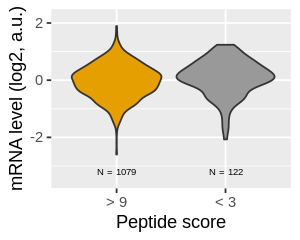

In [121]:
# options(repr.plot.width=1.2, repr.plot.height=1) # Sizing for manuscript
options(repr.plot.width=2.5, repr.plot.height=2) # For ipynb visualization

plot_data <- lfc %>% 
  mutate(type = case_when(
    (motif_source == "han_2020_motifs" & motif_type == "control" & mutant_type == "wildtype") ~ "< 3",
    (motif_source == "human_vk_motif_10"  & mutant_type == "wildtype") ~ "> 9",
    T ~ as.character(NA)
    )) %>% 
  filter(!is.na(type)) %>% 
  filter(!str_detect(aa, "\\*")) %>% 
  print()

label_data <- plot_data %>% 
  group_by(type) %>% 
  summarize(n = paste0("N = ", dplyr::n()))
  
plot_data %>% 
  ggplot(aes(x = fct_rev(type), y = lfc, fill = type)) +
  scale_fill_manual(values = cbPalette) +
  scale_y_continuous(breaks = c(-2, 0, 2), limits = c(-3.5, 2.2)) +
  geom_violin() + 
  geom_text(aes(x = type, label = n), y = -3.2, data = label_data, size = 2) +
  labs(y = "mRNA level (log2, a.u.)", x = "Peptide score") +
  guides(fill = F)

### Calcualte effect size and P-value for motif score violin plot

In [122]:
# Effect size for above plot
plot_data %>% 
  group_by(type) %>% 
  summarize(n = dplyr::n(), median_lfc = median(lfc))

# P-value for above plot
wilcox.test(lfc ~ type, data=plot_data, alternative = "greater")

type,n,median_lfc
<chr>,<int>,<dbl>
< 3,122,0.12176768
> 9,1079,-0.02768762



	Wilcoxon rank sum test with continuity correction

data:  lfc by type
W = 75517, p-value = 0.003786
alternative hypothesis: true location shift is greater than 0


## Histogram of mRNA levels

Skip constructs with stop codons

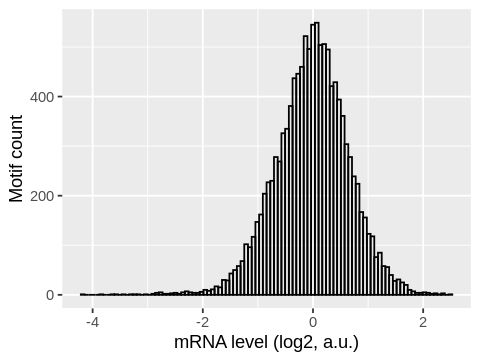

In [97]:
options(repr.plot.width=4, repr.plot.height=3)

lfc %>% 
  filter(!str_detect(aa, "\\*")) %>% 
  ggplot(aes(x = lfc)) +
  geom_histogram(bins = 100, fill = NA, color = 'black') +
  labs(x = "mRNA level (log2, a.u.)", y = "Motif count")

## Plot fold-changes in VK-10 motifs upon KnextV or VnextK mutations

# A tibble: 1,079 × 3
   gene_name name     value
   <chr>     <chr>    <dbl>
 1 PDCD7     KnextV -0.750 
 2 FBXO33    KnextV -0.0476
 3 ADORA3    KnextV  2     
 4 PNISR     KnextV  1.54  
 5 NEXN      KnextV -0.0972
 6 KCNV2     KnextV  1.18  
 7 FAM240A   KnextV  0.362 
 8 GPR139    KnextV  2     
 9 CEP78     KnextV -1.12  
10 NEUROD6   KnextV  0.701 
# … with 1,069 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


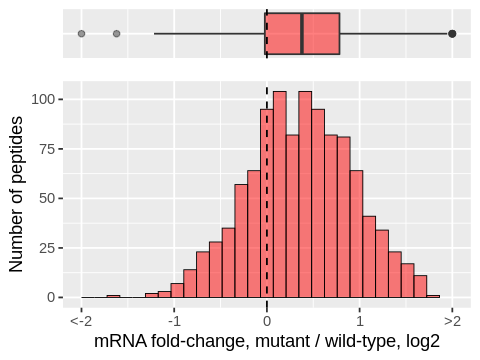

In [98]:
#options(repr.plot.width=1.5, repr.plot.height=1.2) # Sizing for manuscript
options(repr.plot.width=4, repr.plot.height=3) # For ipynb visualization

plot_data <- lfc %>% 
  filter(motif_source == "human_vk_motif_10") %>% 
  filter(!str_detect(aa, "\\*")) %>% 
  select(gene_name, mutant_type, strength, lfc) %>% 
  pivot_wider(names_from = "mutant_type", values_from = "lfc") %>%
  mutate(VnextK = VnextK - wildtype, KnextV = KnextV - wildtype) %>% 
  select(gene_name, KnextV) %>% 
  mutate(KnextV = if_else(KnextV > 2, 2, KnextV)) %>% 
  mutate(KnextV = if_else(KnextV < -2, -2, KnextV)) %>% 
  filter(!is.na(KnextV)) %>% 
  pivot_longer(-gene_name) %>% 
  print()

plot1 <- plot_data %>%
  ggplot(aes(x = value, y = name)) +
  # geom_histogram(fill = "red", color = "NA", alpha = 0.5) +
  geom_boxplot(width=1, fill = "red", alpha = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black")  +
  theme(axis.line = element_blank(), axis.text = element_blank(), 
        axis.ticks = element_blank(), axis.title = element_blank()) +
  scale_x_continuous(labels = c("<-2", -1, 0, 1, ">2"), limits = c(-2, 2)) 
  # geom_hline(yintercept = 0, linetype = "dashed", color = "grey")

plot2 <- plot_data %>%
  ggplot(aes(x = value)) +
  geom_histogram(fill = "red", alpha = 0.5, color = "black", size = 0.25) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black")  +
  # theme(axis.line.y = element_blank(), axis.text.y = element_blank(),
  #       axis.ticks.y = element_blank(), axis.title.y = element_blank()) +
  labs(x = "mRNA fold-change, mutant / wild-type, log2", y = "Number of peptides")  +
  scale_x_continuous(labels = c("<-2", -1, 0, 1, ">2"), limits = c(-2, 2)) 

cowplot::plot_grid(plot1, plot2, ncol = 1, align = "v", rel_heights = c(1,4))

### Calculate P-value and median for Wildtype vs KnextV mutation effects

In [99]:
# P-value for above plot
wilcox.test(plot_data$value, mu = 0)

# Median of above plot
plot_data %>% 
  summarize(n_positive = sum(value > 0), median = median(value))


	Wilcoxon signed rank test with continuity correction

data:  plot_data$value
V = 476108, p-value < 2.2e-16
alternative hypothesis: true location is not equal to 0


n_positive,median
<int>,<dbl>
800,0.3777415


## Calculate bootstrap confidence intervals for LFC of human VK 10 motifs

In [100]:
# Use for calculating bootstrap mRNA level as ratio of mRNA to gRNA counts
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna))
}

lfc_bootstrap <- barcode_counts %>% 
  select(insert_num, barcode_num, library_type, barcode_count) %>% 
  pivot_wider(names_from = "library_type", values_from = "barcode_count") %>% 
  drop_na() %>% 
  group_by(insert_num) %>%
  nest() %>% 
  ungroup() %>% 
  inner_join(insert_annotations, by = "insert_num") %>%
  filter(motif_source == "human_vk_motif_10" | gene_name == "SSRP1") %>% 
  filter(!str_detect(aa, "\\*")) %>% 
  mutate(lfc = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=1000)$t)) %>%
  select(-data) %>% 
  select(gene_name, mutant_type, lfc) %>%
  print()

# A tibble: 3,241 × 3
   gene_name mutant_type lfc              
   <chr>     <chr>       <list>           
 1 ZNF677    VnextK      <dbl [1,000 × 1]>
 2 DCBLD2    KnextV      <dbl [1,000 × 1]>
 3 PGBD1     wildtype    <dbl [1,000 × 1]>
 4 AGGF1     VnextK      <dbl [1,000 × 1]>
 5 RER1      VnextK      <dbl [1,000 × 1]>
 6 ANO1      wildtype    <dbl [1,000 × 1]>
 7 DNAH5     VnextK      <dbl [1,000 × 1]>
 8 RAB35     KnextV      <dbl [1,000 × 1]>
 9 ANO1      KnextV      <dbl [1,000 × 1]>
10 NADK      VnextK      <dbl [1,000 × 1]>
# … with 3,231 more rows


## Calculate quantiles for confidence interval plotting

In [101]:
lfc_iqr <- lfc_bootstrap %>% 
  mutate(lfc_75 = map_dbl(lfc, function(x) quantile(x, 0.95))) %>%
  mutate(lfc_25 = map_dbl(lfc, function(x) quantile(x, 0.05))) %>%
  mutate(lfc_50 = map_dbl(lfc, function(x) quantile(x, 0.5))) %>% 
  mutate(lfc_mean = map_dbl(lfc, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc, sd)) %>%
  select(-lfc) %>% 
  print()

# A tibble: 3,241 × 7
   gene_name mutant_type  lfc_75 lfc_25 lfc_50 lfc_mean lfc_sd
   <chr>     <chr>         <dbl>  <dbl>  <dbl>    <dbl>  <dbl>
 1 ZNF677    VnextK      -1.43   -1.88  -1.64    -1.65   0.136
 2 DCBLD2    KnextV      -1.03   -1.99  -1.54    -1.52   0.295
 3 PGBD1     wildtype    -1.10   -2.27  -1.68    -1.69   0.364
 4 AGGF1     VnextK      -1.46   -2.27  -1.87    -1.86   0.256
 5 RER1      VnextK      -1.80   -2.63  -2.20    -2.21   0.256
 6 ANO1      wildtype    -1.59   -2.12  -1.86    -1.86   0.161
 7 DNAH5     VnextK      -0.475  -1.21  -0.807   -0.820  0.220
 8 RAB35     KnextV      -0.0659 -0.787 -0.419   -0.420  0.220
 9 ANO1      KnextV      -0.965  -1.63  -1.29    -1.29   0.203
10 NADK      VnextK      -1.09   -1.80  -1.43    -1.44   0.216
# … with 3,231 more rows


## Calculate bootstrap P-values for significant change upon KnextV and VnextK mutations

In [102]:
vkmutants_pvals <- lfc_bootstrap %>% 
  pivot_wider(names_from = "mutant_type", values_from = "lfc") %>% 
  drop_na() %>% 
  mutate(KnextV_pval_greater = map2_dbl(KnextV, wildtype,
                                        function(x, y) wilcox.test(x, y, alternative = "greater")$p.value)) %>%
  mutate(KnextV_pval_less = map2_dbl(KnextV, wildtype,
                                        function(x, y) wilcox.test(x, y, alternative = "less")$p.value)) %>%
  mutate(VnextK_pval_greater = map2_dbl(VnextK, wildtype,
                                        function(x, y) wilcox.test(x, y, alternative = "greater")$p.value)) %>%
  mutate(VnextK_pval_less = map2_dbl(VnextK, wildtype,
                                        function(x, y) wilcox.test(x, y, alternative = "less")$p.value)) %>%
  # Benjamini-Hochberg FDR correction
  mutate(KnextV_pval_greater = p.adjust(KnextV_pval_greater, method = "fdr")) %>%
  mutate(KnextV_pval_less = p.adjust(KnextV_pval_less, method = "fdr")) %>%
  mutate(VnextK_pval_greater = p.adjust(VnextK_pval_greater, method = "fdr")) %>%
  mutate(VnextK_pval_less = p.adjust(VnextK_pval_less, method = "fdr")) %>%
  select(gene_name, KnextV_pval_greater, KnextV_pval_less, VnextK_pval_greater, VnextK_pval_less) %>%
  print()

# A tibble: 1,079 × 5
   gene_name KnextV_pval_gre… KnextV_pval_less VnextK_pval_gre… VnextK_pval_less
   <chr>                <dbl>            <dbl>            <dbl>            <dbl>
 1 ZNF677           7.33e- 74        1   e+  0         1   e+ 0        0        
 2 DCBLD2           1   e+  0        2.63e-156         1   e+ 0        1.22e-190
 3 PGBD1            1.49e-195        1   e+  0         1   e+ 0        1.82e-  9
 4 AGGF1            1   e+  0        1.94e-  1         9.71e- 2        1   e+  0
 5 RER1             5.81e- 61        1   e+  0         1   e+ 0        0        
 6 ANO1             1.64e-305        1   e+  0         1.60e-92        1   e+  0
 7 DNAH5            1   e+  0        7.82e-  2         3.96e-36        1   e+  0
 8 RAB35            7.15e- 55        1   e+  0         3.38e-63        1   e+  0
 9 NADK             1   e+  0        7.50e-125         1   e+ 0        9.72e-224
10 PGBD2            1   e+  0        8.44e- 68         1   e+ 0        1.44e-306
# … wi

In [103]:
vkmutants_pvals %>% 
  filter(gene_name == "VAPA") %>% 
  arrange(KnextV_pval_greater)

gene_name,KnextV_pval_greater,KnextV_pval_less,VnextK_pval_greater,VnextK_pval_less
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
VAPA,1.346296e-306,1,7.224354e-270,1


## How many human VK10 peptides have higher or lower mRNA level upon KnextV or VnextK  mutations?

In [120]:
vkmutants_pvals %>% 
  summarize(VnextK_n_greater = sum(VnextK_pval_greater < 0.05), 
            VnextK_n_less = sum(VnextK_pval_less < 0.05),
            KnextV_n_greater = sum(KnextV_pval_greater < 0.05), 
            KnextV_n_less = sum(KnextV_pval_less < 0.05),
            )

VnextK_n_greater,VnextK_n_less,KnextV_n_greater,KnextV_n_less
<int>,<int>,<int>,<int>
641,401,781,262


## Confirm that known 8x dicodon stall motifs are destabilizing

In [105]:
known_stalls <- lfc %>% 
  filter(motif_source == "control_motifs") %>% 
  select(aa, lfc, seq, starts_with("count"), starts_with("n_barcodes")) %>% 
  mutate(lfc = round(lfc, 2))

known_stalls

aa,lfc,seq,count_grna,count_mrna,n_barcodes_grna,n_barcodes_mrna
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>
RHRHRHRHRHRHRHRH,-1.84,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,6718,1458,97,105
VKVKVKVKVKVKVKVK,-1.78,GTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAA,8980,2036,104,112
SFSFSFSFSFSFSFSF,-1.20,AGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTC,16902,5719,158,164
SSSSSSSSKKKKKKKK,-0.47,TCATCATCATCATCATCATCATCAAAGAAGAAGAAGAAGAAGAAGAAG,11059,6222,81,87
FFFFFFFFQQQQQQQQ,-0.39,TTTTTTTTTTTTTTTTTTTTTTTTCAGCAGCAGCAGCAGCAGCAGCAG,21791,12929,189,197
SKSKSKSKSKSKSKSK,-0.36,TCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAG,14537,8806,126,133
QSQSQSQSQSQSQSQS,-0.34,CAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGT,11019,6789,87,95
FQFQFQFQFQFQFQFQ,-0.24,TTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAG,16643,10980,150,159
VSVSVSVSVSVSVSVS,-0.12,GTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCA,14019,10038,124,134


## Read in Uniprot-annotated Beta stranded motifs

NOTE: We currently don't have code added to generate these uniprot structure tables. Added tables manually for now. We can go back and add the analysis code to generate these later. 

In [108]:
# Need to add this table to the repo to do this analysis
stranded_stalls <- read_tsv("../tables/2021-04-07_strand-dipeptide-motifs-in-12k-library.tsv") %>% 
    print()

Rows: 157 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, aa
dbl (6): loc_12k, stall_score, strand_score, stall_strand_product, lv_distan...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 157 × 8
   gene_name loc_12k stall_score strand_score stall_strand_pr… aa    lv_distance
   <chr>       <dbl>       <dbl>        <dbl>            <dbl> <chr>       <dbl>
 1 ARID4A        305          13           16              208 AFCE…           4
 2 LGALS2        446          12           15              180 SPGS…           4
 3 CYP17A1      1513          16           11              176 LEGI…           4
 4 CRBN          509          11           16              176 GIEI…           4
 5 ARRDC3        372          11           16              176 VTGE…           4
 6 VPS26A        493          12           14              168 SYIG…           4
 7 MAJIN         356          12           14              168 PFPE…           4
 8 ITGB1BP1      411          12           14              168 NSDT…           4
 9 LLGL2        2595          13           12              156 SEEQ…           4
10 IL6R         1034          13           12              156 WQDP…           6
# … with

In [134]:
lfc %>%
  inner_join(select(stranded_stalls, strand_score, stall_score, gene_name), by = c("gene_name")) %>%
  select(strand_score, stall_score, everything()) %>% print

# A tibble: 413 × 16
   strand_score stall_score motif_source      gene_name motif_type mutant_type
          <dbl>       <dbl> <chr>             <chr>     <chr>      <chr>      
 1           12           7 rg4               KDM1A     NA         NA         
 2           14          11 human_vk_motif_10 RAB12     stall      wildtype   
 3           13          10 human_vk_motif_10 RPS6KA6   stall      VnextK     
 4           16           6 weber_2020_motifs SYK       stall      wildtype   
 5           11          12 rg4               NADK      NA         NA         
 6           11           1 han_2020_motifs   MTAP      control    wildtype   
 7           11          11 rg4               COPA      NA         NA         
 8           13           7 weber_2020_motifs USP19     stall      wildtype   
 9            8          13 human_vk_motif_10 LEO1      stall      VnextK     
10           14           6 weber_2020_motifs SYT1      stall      wildtype   
# … with 403 more rows, and 10 

## Look at Uniprot entries for all 12K library motifs irrespective of structure

In [135]:
uniprot_12k <- read_tsv("../tables/2021-08-03_secondary-structure-motifs-in-12k-library.tsv") %>% 
  select(gene_name, helix, strand, turn) %>% 
  inner_join(lfc, by = c("gene_name")) %>%
  # filter(strand > 8, lfc < -0.75) %>%
  # filter(mutant_type == "wildtype") %>%
  arrange(-strand,lfc) %>% print


Rows: 1975 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): group, mutant_type, motif_source, aa, seq, gene_name, transcript_id...
dbl (7): motif_num, strength, loc, insert_num, helix, strand, turn

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 5,119 × 17
   gene_name helix strand  turn motif_source     motif_type mutant_type strength
   <chr>     <dbl>  <dbl> <dbl> <chr>            <chr>      <chr>          <dbl>
 1 SYK           0     23     0 weber_2020_moti… stall      wildtype           6
 2 ARRDC3        0     23     0 human_vk_motif_… stall      wildtype          11
 3 ARRDC3        0     23     0 human_vk_motif_… stall      KnextV            11
 4 ARRDC3        0     23     0 human_vk_motif_… stall      VnextK            11
 5 SYK           0     23     0 weber_2020_moti… stall      KnextV             6
 6 EFHC2         0     22     0 human_vk_motif_… stall      wildtype          10
 7 CRBN          0     22     0 human_vk_motif_… stall      VnextK            11
 8 CRBN          0     22     0 human_vk_motif_… stall      KnextV            11
 9 CRBN          0     22     0 human_vk_motif_… stall      wildtype          11
10 EFHC2         0     22     0 human_vk_motif_… stall      KnextV            10
# … w

## Read in S4Pred propensities

- NOTE: Again, we need to generate these tables computationally in this repo. For now I'm adding them manually. 

In [137]:
s4pred_detailed <- read_tsv("../tables/20210503_endo12k_ss_prediction.tsv.gz") %>% 
  print()

s4pred <- read_tsv("../tables/20210503_endo12k_avg_ss_prediction.tsv.gz") %>% 
   # Unclear why, but this adds "..." into the index_1 and 2 names. Remove these dots.
   rename(index_1 = index...1, index_2 = index...2) %>% print 

Rows: 432000 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): ss
dbl (3): index, loc, p

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 432,000 × 4
   index   loc ss        p
   <dbl> <dbl> <chr> <dbl>
 1     0     0 turn  0.991
 2     0     1 turn  0.966
 3     0     2 turn  0.892
 4     0     3 turn  0.692
 5     0     4 turn  0.653
 6     0     5 turn  0.658
 7     0     6 turn  0.627
 8     0     7 turn  0.635
 9     0     8 turn  0.417
10     0     9 turn  0.356
# … with 431,990 more rows


New names:
• `index` -> `index...1`
• `index` -> `index...2`
Rows: 6000 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (7): mutant_type, motif_source, aa, seq, gene_name, transcript_id, motif...
dbl (8): index...1, index...2, helix, strand, turn, motif_num, strength, loc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6,000 × 15
   index_1 index_2   helix strand  turn motif_num mutant_type strength
     <dbl>   <dbl>   <dbl>  <dbl> <dbl>     <dbl> <chr>          <dbl>
 1       0     628 0.00246  0.649 0.348       629 wildtype          10
 2       1     286 0.00326  0.643 0.353       287 wildtype          11
 3       2     675 0.0277   0.635 0.337       676 wildtype          10
 4       3     307 0.00461  0.633 0.363       308 wildtype          11
 5       4     754 0.00358  0.627 0.369       755 wildtype          10
 6       5    1518 0.0158   0.627 0.357      1519 wildtype           7
 7       6     801 0.00385  0.625 0.371       802 wildtype          10
 8       7    1024 0.0545   0.624 0.321      1025 wildtype          10
 9       8     489 0.0278   0.623 0.349       490 wildtype          11
10       9     855 0.00536  0.620 0.375       856 wildtype          10
# … with 5,990 more rows, and 7 more variables: motif_source <chr>, aa <chr>,
#   seq <chr>, gene_name <chr>, transcript_id <

## Highlight specific endogenous Beta strand + stall candidates

All four inserts below have uniprot annotated β-strands:
- Look at destabilizing β-stranded RAB12 case study further below. Has a RG stalling motif right at the turn.
- ITGB1BP1 has an abnormally long β-strand of 14 amino acids. Destabiliziing as well. Has lot of aromatics.
- EFHC2 has an abnormally long β-strand of 14 amino acids. Destabilizing as well. Has lot of aromatics.
- SSRP1 is interesting because it is destabilizing, stranded, rescued by KnextV, and also has high ribosome density in Han 2020.

### Plot LFC for candidates of interest

# A tibble: 8 × 9
  gene_name mutant_type  lfc_75 lfc_25 lfc_50 lfc_mean lfc_sd order  yloc
  <fct>     <fct>         <dbl>  <dbl>  <dbl>    <dbl>  <dbl> <dbl> <dbl>
1 EFHC2     wt          -0.749  -1.71  -1.22    -1.23   0.296 -1.23     5
2 SSRP1     wt          -1.05   -1.84  -1.44    -1.44   0.242 -1.44    11
3 ITGB1BP1  wt          -0.764  -1.75  -1.28    -1.27   0.303 -1.27     8
4 ITGB1BP1  mut          0.0673 -0.556 -0.238   -0.233  0.191 -1.27     7
5 RAB12     wt          -1.60   -2.59  -2.11    -2.10   0.300 -2.10    14
6 EFHC2     mut          0.143  -0.745 -0.283   -0.293  0.269 -1.23     4
7 RAB12     mut         -0.342  -0.910 -0.615   -0.615  0.178 -2.10    13
8 SSRP1     mut          0.390  -0.140  0.119    0.122  0.162 -1.44    10


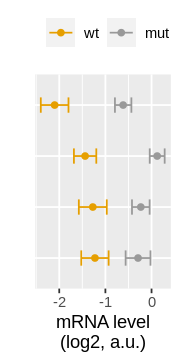

In [131]:
# options(repr.plot.width=0.7, repr.plot.height=2) # Sizing for manuscript figure
options(repr.plot.width=1.5, repr.plot.height=3) # For visualizing in ipynb

goi <- c("RAB12", "ITGB1BP1", "EFHC2", "SSRP1")

plot_data <- lfc_iqr %>% 
  filter(mutant_type %in% c("wildtype", "KnextV")) %>% 
  filter(gene_name %in% goi) %>% 
  mutate(mutant_type = fct_rev(if_else(mutant_type == "KnextV", "mut", "wt"))) %>%
  group_by(gene_name) %>%
  mutate(order = lfc_mean[mutant_type == "wt"]) %>%
  mutate(yloc = seq(n(), 1, -1)) %>%
  ungroup() %>%
  mutate(gene_name = fct_rev(fct_reorder(gene_name, order))) %>% 
  mutate(yloc = yloc + 3*group_indices(., gene_name)) %>%
  print()

gene_order <- plot_data %>% 
  select(gene_name, mutant_type, yloc)

plot_data %>% 
  ggplot(aes(x = lfc_mean, xmin = lfc_mean - lfc_sd, xmax = lfc_mean + lfc_sd, y = gene_name, color = mutant_type)) +
  geom_errorbar(width = 0.3) +
  geom_point() +
  scale_color_manual(values = cbPalette[c(2,1)]) +
  theme(axis.ticks.y = element_blank(), 
        axis.text.y = element_blank(),
        axis.line.y = element_blank(),
        legend.position = "top") +
  scale_x_continuous(breaks = seq(-2,0)) +
  labs(x = "mRNA level\n(log2, a.u.)", color = "", y = "")

### Plot S4Pred for genes of interest

# A tibble: 192 × 16
   index   loc ss           p index_2 strand motif_num mutant_type strength
   <dbl> <dbl> <chr>    <dbl>   <dbl>  <dbl>     <dbl> <fct>          <dbl>
 1    33     0 strand 0.0151      410  0.567       411 wt                11
 2    33     1 strand 0.0600      410  0.567       411 wt                11
 3    33     2 strand 0.233       410  0.567       411 wt                11
 4    33     3 strand 0.264       410  0.567       411 wt                11
 5    33     4 strand 0.455       410  0.567       411 wt                11
 6    33     5 strand 0.442       410  0.567       411 wt                11
 7    33     6 strand 0.368       410  0.567       411 wt                11
 8    33     7 strand 0.173       410  0.567       411 wt                11
 9    33     8 strand 0.0224      410  0.567       411 wt                11
10    33     9 strand 0.00641     410  0.567       411 wt                11
# … with 182 more rows, and 7 more variables: motif_source <chr>, a

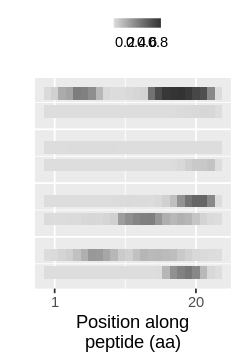

In [132]:
# options(repr.plot.width=1.2, repr.plot.height=1.9) # Sizing for manuscript figure
options(repr.plot.width=2, repr.plot.height=3) # For visualizing in ipynb

plot_data <- s4pred_detailed %>%
  right_join(s4pred %>% select(-loc, -helix, -turn), by = c("index" = "index_1")) %>%
  filter(mutant_type %in% c("wildtype", "KnextV")) %>%
  filter(gene_name %in% goi) %>% 
  mutate(mutant_type = fct_rev(if_else(mutant_type == "KnextV", "mut", "wt"))) %>%
  left_join(gene_order, by = c("gene_name", "mutant_type")) %>% 
  filter(ss == "strand") %>% 
  print()

plot_data %>%
  ggplot(aes(x = loc, y = yloc, fill = p)) +
  geom_tile(height = 0.7) +
  scale_fill_gradient(high = "#333333", low = "#dddddd") +
  theme(axis.ticks.y = element_blank(),
        axis.text.y = element_blank(),
        axis.line = element_blank(),
        legend.position = "top") +
  guides(fill = guide_colorbar(barheight = unit(0.2, "cm"), barwidth = unit(1.0, "cm"), ticks = F)) +
  scale_x_continuous(breaks = c(1,20)) +
  labs(x = "Position along\npeptide (aa)", fill = "", y = "")

### Show selected gene sequences

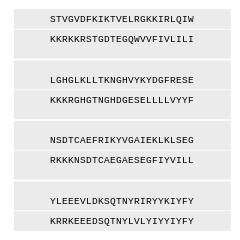

In [133]:
# options(repr.plot.width=1.2, repr.plot.height=1.9) # Sizing for manuscript figure
options(repr.plot.width=2, repr.plot.height=2) # For visualizing in ipynb

plot_data <- lfc %>% 
  filter(mutant_type %in% c("wildtype", "KnextV")) %>%
  filter(gene_name %in% goi) %>% 
  mutate(mutant_type = fct_rev(if_else(mutant_type == "KnextV", "mut", "wt"))) %>%
  right_join(gene_order, by = c("gene_name", "mutant_type")) %>% 
  arrange(-yloc)

plot_data %>% 
  ggplot(aes(label = aa, y = yloc)) +
  geom_text(x = 0.5, size = 2, family = "Courier") +
  theme(axis.ticks = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.line = element_blank(),
        legend.position = "top") 

## Do S4-predicted β-strand stall motifs have lower mRNA stability than other stall motifs?

We consider all motifs with stall strength >= 10.

We classify motifs with average p_strand >= 0.5 as strands. 

Based on above, it looks like stranded motifs have a slightly lower mRNA level than non-stranded motifs (0.23).

# A tibble: 1,079 × 17
    strand   helix motif_source  gene_name motif_type mutant_type strength   lfc
     <dbl>   <dbl> <chr>         <chr>     <chr>      <chr>          <dbl> <dbl>
 1 0.516   0.0840  human_vk_mot… ADORA3    stall      wildtype          14 -2.60
 2 0.109   0.160   human_vk_mot… PNISR     stall      wildtype          12 -2.51
 3 0.272   0.101   human_vk_mot… GPR139    stall      wildtype          10 -2.16
 4 0.224   0.133   human_vk_mot… STAB2     stall      wildtype          12 -1.83
 5 0.567   0.00978 human_vk_mot… RAB12     stall      wildtype          11 -1.73
 6 0.0655  0.0450  human_vk_mot… SYCP2     stall      wildtype          10 -1.60
 7 0.116   0.417   human_vk_mot… SATB2     stall      wildtype          10 -1.56
 8 0.0328  0.393   human_vk_mot… RESF1     stall      wildtype          13 -1.53
 9 0.00127 0.733   human_vk_mot… AGGF1     stall      wildtype          10 -1.53
10 0.169   0.283   human_vk_mot… ANO1      stall      wildtype          11 -1.47
# … w

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


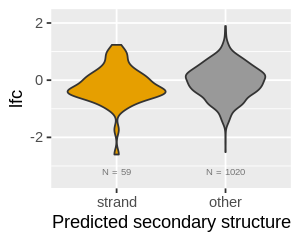

In [123]:
# options(repr.plot.width=1.2, repr.plot.height=1) # Sizing for manuscript figure
options(repr.plot.width=2.5, repr.plot.height=2) # For visualizing in ipynb

plot_data <- lfc %>% 
  filter(mutant_type == "wildtype") %>%
  filter(!str_detect(aa, "\\*")) %>% 
  left_join(s4pred %>% select(helix, strand, motif_source, gene_name, mutant_type), by = c("motif_source", "gene_name", "mutant_type")) %>% 
  select(strand, helix, everything()) %>% 
  filter(motif_source == "human_vk_motif_10") %>% 
  mutate(ss = fct_rev(case_when(strand >= 0.5 ~ "strand",
                        T ~ "other"
                        ))) %>% 
  print()

label_data <- plot_data %>% 
  group_by(ss) %>% 
  summarize(n = paste0("N = ", dplyr::n()))
  

plot_data %>% 
  ggplot(aes(x = ss, y = lfc, fill = ss)) +
  scale_fill_manual(values = cbPalette[c(2,1)]) +
  geom_violin() +
  geom_text(aes(x = ss, label = n), y = -3.2, data = label_data, size = 2, alpha = 0.5) +
  guides(fill = F) + 
  scale_y_continuous(breaks = c(-2, 0, 2), limits = c(-3.5, 2.2)) +
  labs(x = "Predicted secondary structure")

### Calculate effect size and P-value for this Stands vs Other comparison

In [124]:
# Effect size for above plot
plot_data %>% 
  group_by(ss) %>% 
  summarize(n = dplyr::n(), median_lfc = median(lfc))

# P-value for above plot
wilcox.test(lfc ~ ss, data=plot_data %>% filter(ss != "helix"), alternative = "less")

ss,n,median_lfc
<fct>,<int>,<dbl>
strand,59,-0.28644336
other,1020,-0.01909049



	Wilcoxon rank sum test with continuity correction

data:  lfc by ss
W = 25347, p-value = 0.02079
alternative hypothesis: true location shift is less than 0
